# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

### Sarah
- Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type.
- you could build a machine learning model that predicts how much someone will spend based on demographics and offer type.
- Or you could build a model that predicts whether or not someone will respond to an offer. 
-  You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).


- ## Q
- which offer get completed the most? there are 3 offer type 
                bogo             4
                discount         4
                informational    2
  ############ all complated has no offer id
                
- Dose income effect customer completing the offer?

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.shape , profile.shape ,transcript.shape

((10, 6), (17000, 5), (306534, 4))

## portfolio

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [5]:
# extract all channels
channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))

In [6]:
# split the channel into different attribute
for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})

In [7]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,email,social,web,mobile
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0


In [8]:
del portfolio['channels']

## transcrip

In [9]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [10]:
transcript.event.value_counts()/len(transcript.event)

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

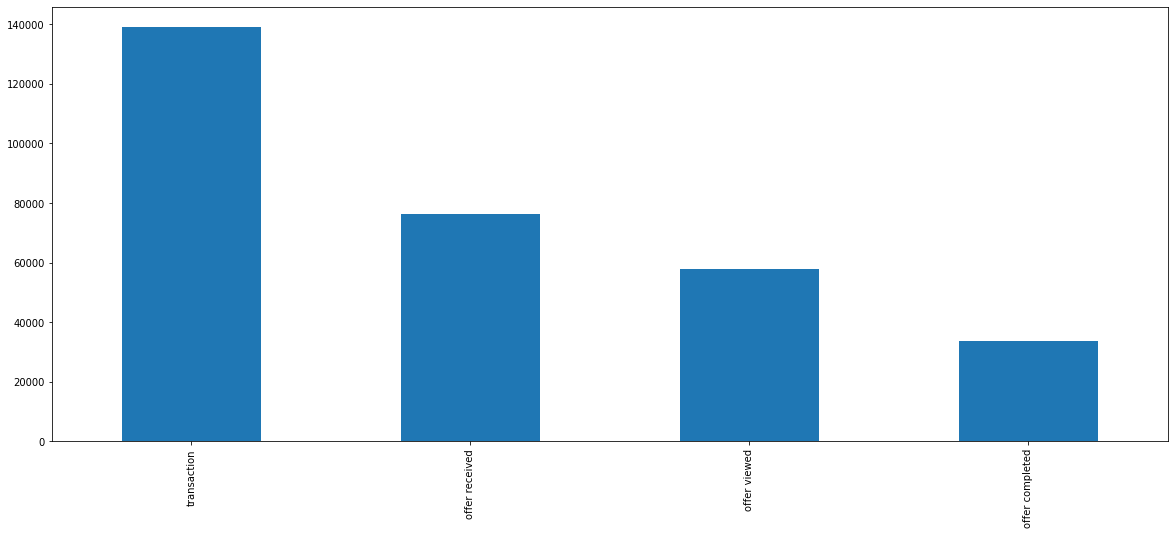

In [11]:
transcript.event.value_counts().plot(kind='bar',figsize=(20,8));

In [12]:
# check if there is missing values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [13]:
# check data types
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [14]:
# clean the vlaue
transcript['offer_id'] = transcript.value.map(lambda x : x.get('offer id'))

In [15]:
del transcript['value']

## profile 

In [16]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [17]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [18]:
profile["became_member_on"] = pd.to_datetime(profile.became_member_on.apply(str))

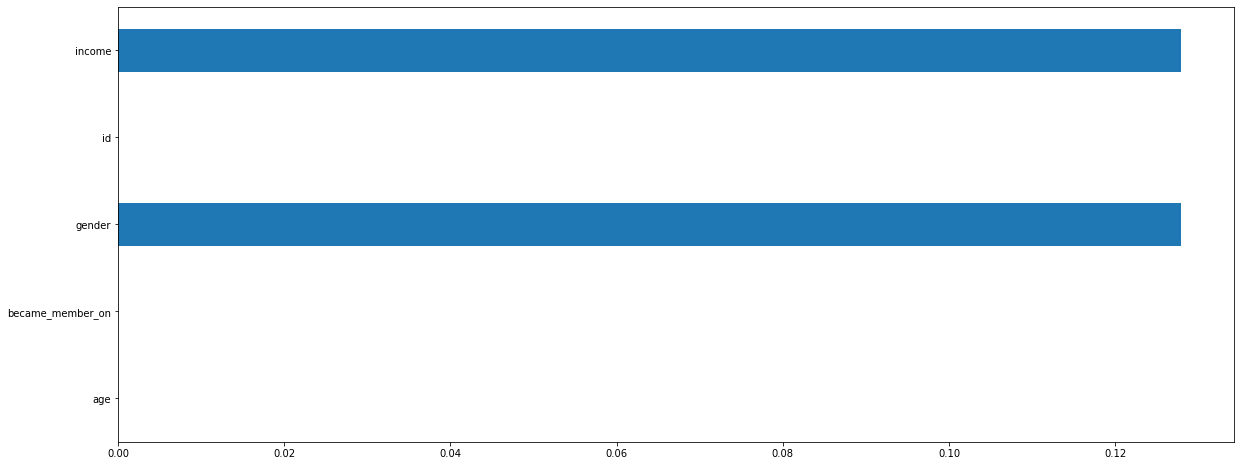

In [19]:
(profile.isna().sum()/len(profile)).plot(kind='barh',figsize=(20,8));

Here we can see here 'gender ' and 'income ' columns have same number of missing values which is less than 15% so I decide to drop all missing data here since it has no effect.

In [20]:
profile.dropna(inplace=True)

In [21]:
# double check there no nulls 
profile.isna().sum()/len(profile)

age                 0.0
became_member_on    0.0
gender              0.0
id                  0.0
income              0.0
dtype: float64

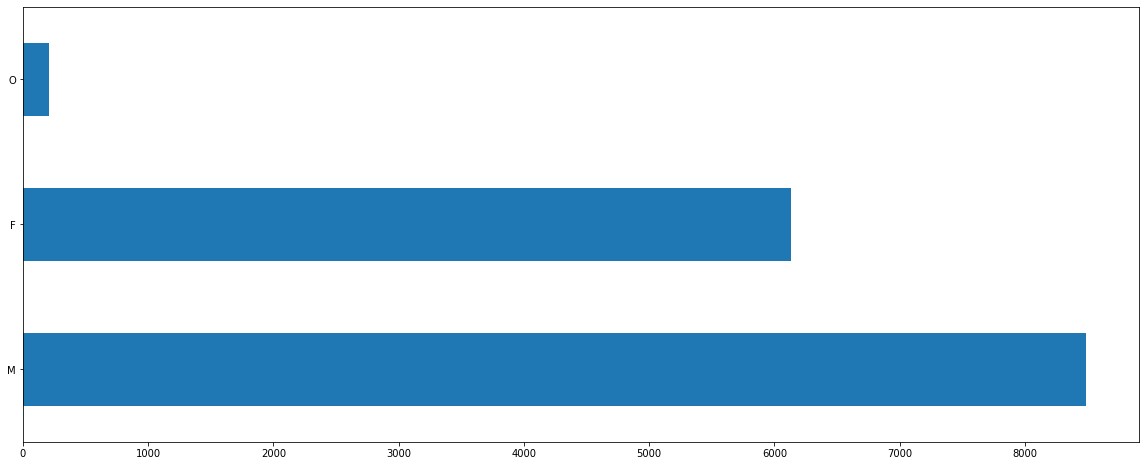

In [22]:
profile.gender.value_counts().plot(kind='barh',figsize=(20,8));
# males more

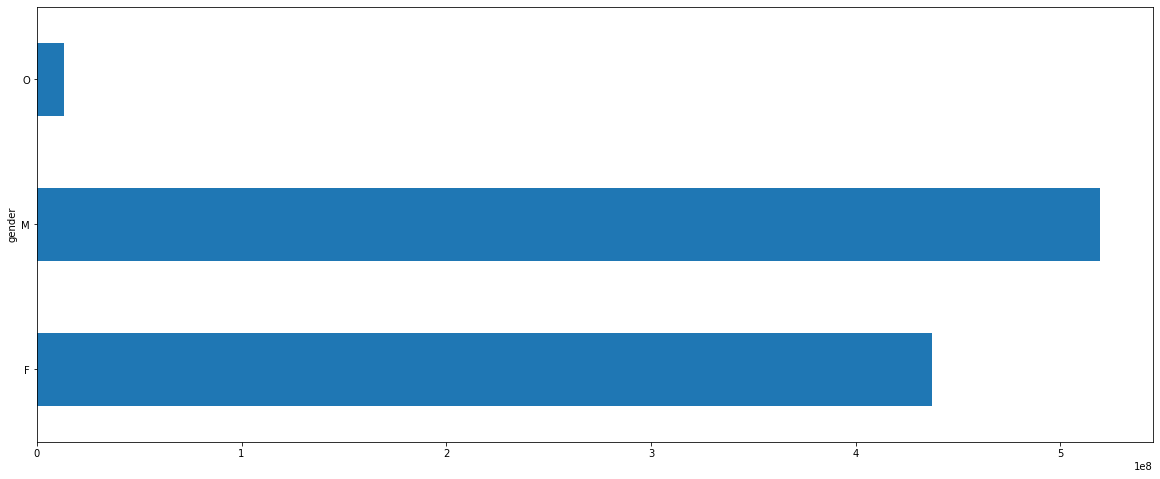

In [23]:
profile.groupby('gender')['income'].sum().plot(kind='barh',figsize=(20,8));

In [33]:
transcript.duplicated().sum(), portfolio.duplicated().sum(), profile.duplicated().sum()

(0, 0, 0)

In [32]:
# drop the duplicated value, and reset the index
transcript.drop_duplicates(inplace=True)

transcript.reset_index(drop=True, inplace=True)

In [35]:
# merge the data
data = transcript.merge(profile, how="left", left_on="person", right_on="id", validate="m:1")
data.drop("id", inplace=True, axis=1)
data = data.merge(portfolio, how="left", left_on="offer_id", right_on="id", validate="m:1",
                 suffixes=("_transcript", "_portfolia"))
data.drop("id", inplace=True, axis=1)

In [36]:
data["offer_type_fix"] = data.offer_type.fillna("No_offer")
data["event_fix"] = data.event
data.loc[data.offer_id.isnull(), "event_fix"] = "No_offer_completed"

In [39]:
group_data = data.groupby(["person", "offer_id", "event"]).size().reset_index()
group_data.rename({0:"count"}, axis=1, inplace=True)
offer_person = group_data.pivot_table(
    index=["person", "offer_id"],  columns=["event"], values=["count"], aggfunc="count"
    ).reset_index()
offer_person.columns = ["person", "offer_id", "offer_completed", "offer_received"]

In [40]:
# fill the missing value with 0
offer_person.fillna(0, inplace=True)

In [41]:
offer_person = offer_person.merge(portfolio, left_on="offer_id", right_on="id", how="left")
offer_person.drop("id", axis=1, inplace=True)

In [42]:
offer_person.head()

,person,offer_id,offer_completed,offer_received,difficulty,duration,offer_type,reward,email,social,web,mobile
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1.0,0.0,10,7,discount,2,1,0,1,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0,4,informational,0,1,0,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,0,3,informational,0,1,1,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,5,5,bogo,5,1,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,10,10,discount,2,1,1,1,1


In [43]:
no_offer_person = data.loc[data.offer_id.isnull()].groupby(["person"]).size().reset_index()
no_offer_person.rename({0:"count"}, axis=1, inplace=True)

In [44]:
no_offer_person.head()

,person,count
0,0009655768c64bdeb2e877511632db8f,11
1,00116118485d4dfda04fdbaba9a87b5c,3
2,0011e0d4e6b944f998e987f904e8c1e5,7
3,0020c2b971eb4e9188eac86d93036a77,10
4,0020ccbbb6d84e358d3414a3ff76cffd,15
